In [ ]:
from zipfile import ZipFile
import os
import string
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import cv2
import imutils
from skimage.feature import hog
from skimage import data, exposure
# from google.colab import drive
# drive.mount('/content/drive')

# Data extraction

Opening the zip file that contains all the images...

In [ ]:
def zipExtracting(path):
  '''This function allows to unzip a folder located in path'''
  with ZipFile(path, 'r') as zipFile:
      print('Unzipping...')
      zipFile.extractall()
      print('Done!')
    
zipPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/ASL Dataset.zip'
zipExtracting(zipPath)

In [ ]:
def onlyLetters(name): 
  '''This function takes a string in input and return all the characters before 
  a number in the string'''
  newName = ""
  for letter in name:
      if letter.isalpha():
          newName += letter
      else:
          break
  return newName

def getImagesPath(path):
  '''Explores all the images contained in the folder and creates a dictionary 
  where  the keys are the letters contained in the folder, i.e. the letters for 
  which I have a collection of images, while the values are for every letter a 
  list that contains all the images' path for the key letter.'''

  letterDi = {}
  letterDiKeys = [letter for letter in string.ascii_uppercase] + ['del', 'nothing', 'space']
  # string.ascii_uppercase returns the upper-case alphabet
  
  for letterDiKey in letterDiKeys:
    letterDi[letterDiKey] = [] # initialize a letter: [] dictionary

  for root, dirs, images in os.walk(path):
    for image in images:
      if image.endswith(".jpg"):
        imagePath = os.path.join(root, image)
        imageLetter = onlyLetters(image)
        if len(letterDi[imageLetter]) < 1000:
          letterDi[imageLetter] = letterDi[imageLetter] + [imagePath]
        else:
          pass
  return(letterDi)

filesPath = '/content/asl_alphabet_train/asl_alphabet_train'
letterDi = getImagesPath(filesPath)

The `generateFullDataset` function consents to transform the previous dictionary in two elements: a list of labels (response variable) and a tensor of black-and-white images. The created dataset is then saved. Changing the resize parameter allows to save a dataset where images dimension are more small in order to have less computational weight.

In [ ]:
# old function: estimated time to complete 6h

# def generateFullDataset(letterDictionary, sPath, resize = .10, xName = 'images.npy', yName = 'labels.npy'):
#   label = [] # response vector
#   mySize = int(resize*200)
#   Ximg = np.empty((0, mySize, mySize)) # images

#   # Creating a TensorFlow session and using the GPU if available
#   config = tf.compat.v1.ConfigProto()
#   config.gpu_options.allow_growth = True
#   sess = tf.compat.v1.Session(config=config)

#   with sess.as_default():
#     print('Extracting the data...')
#     for letter in tqdm(letterDictionary.keys()):
#       nImages = len(letterDictionary[letter])
#       label = label + [letter]*nImages # the response repeats every letter nImages times
#       for image in letterDictionary[letter]:
#         image = cv2.imread(image) # load the image,
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert it to grayscale,
#         gray = cv2.resize(gray, (mySize, mySize)) # need to convert to 80x80 due to RAM limitations
#         img = np.asarray(gray) # converting to a matrix

'''The problem with np.append() is that it creates a new, larger array every time an element is added to it, 
using up more memory and slowing down the code as it grows in size. This can cause memory fragmentation and lead to poor performance. 
It is better to use numpy.concatenate() instead to append elements to an array in a more memory-efficient way.'''
###########
#         Ximg = np.append(Ximg, [img], axis = 0)
###########
#     print('\nDone!')
#     print('\n')
#     print('Saving the data...')
#     np.save(''.join((sPath, xName)), Ximg)
#     np.save(''.join((sPath, yName)), label)
#     print('Done!')

# savePath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/'
# generateFullDataset(letterDi, savePath)

'The problem with np.append() is that it creates a new, larger array every time an element is added to it, \nusing up more memory and slowing down the code as it grows in size. This can cause memory fragmentation and lead to poor performance. \nIt is better to use numpy.concatenate() instead to append elements to an array in a more memory-efficient way.'

In [ ]:
# new code: same task executed in 2 min 2 sec

def generateFullDataset(letterDictionary, sPath, resize=0.25, xName='images.npy', yName='labels.npy'):
    label = []  # response vector
    mySize = int(resize * 200)
    Ximg = np.empty((0, mySize, mySize))  # images

    print('Extracting the data...')
    for letter in tqdm(letterDictionary.keys()):
      nImages = len(letterDictionary[letter])
      label = label + [letter] * nImages  # the response repeats every letter nImages times
      tempXimg = np.empty((nImages, mySize, mySize))  # create empty array
      for i, image in enumerate(letterDictionary[letter]):
        image = cv2.imread(image) # load the image,
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert it to grayscale,
        gray = cv2.resize(gray, (mySize, mySize)) # need to convert to 50x50 due to RAM limitations
        tempXimg[i] = np.asarray(gray)  # add image to tempXimg array
      Ximg = np.concatenate((Ximg, tempXimg), axis=0)  # concatenate tempXimg with Ximg
    print('\nDone!')
    print('\n')
    print('Saving the data...')
    np.save(''.join((sPath, xName)), Ximg)
    np.save(''.join((sPath, yName)), label)
    print('Done!')


savePath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/'
generateFullDataset(letterDi, savePath)

Extracting the data...


100%|██████████| 29/29 [00:33<00:00,  1.16s/it]



Done!


Saving the data...
Done!


# Load the data

Recalling tensors from the path.

In [ ]:
# savePath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/'
savePath = 'G:/Il mio Drive/Secondo Anno Magistrale/Machine Learning/'
def loadData(sPath):
  images = np.load(savePath+'images.npy')
  labels = np.load(savePath+'labels.npy')
  return(images, labels)

X, y = loadData(savePath)

Response variable from letter to numbers 

In [ ]:
y.shape
labEnc = LabelEncoder()
y_num = labEnc.fit_transform(y)
print(y_num, y)

[ 0  0  0 ... 28 28 28] ['A' 'A' 'A' ... 'space' 'space' 'space']


# EDA

Number of images for every category.

A sample of labeled images.

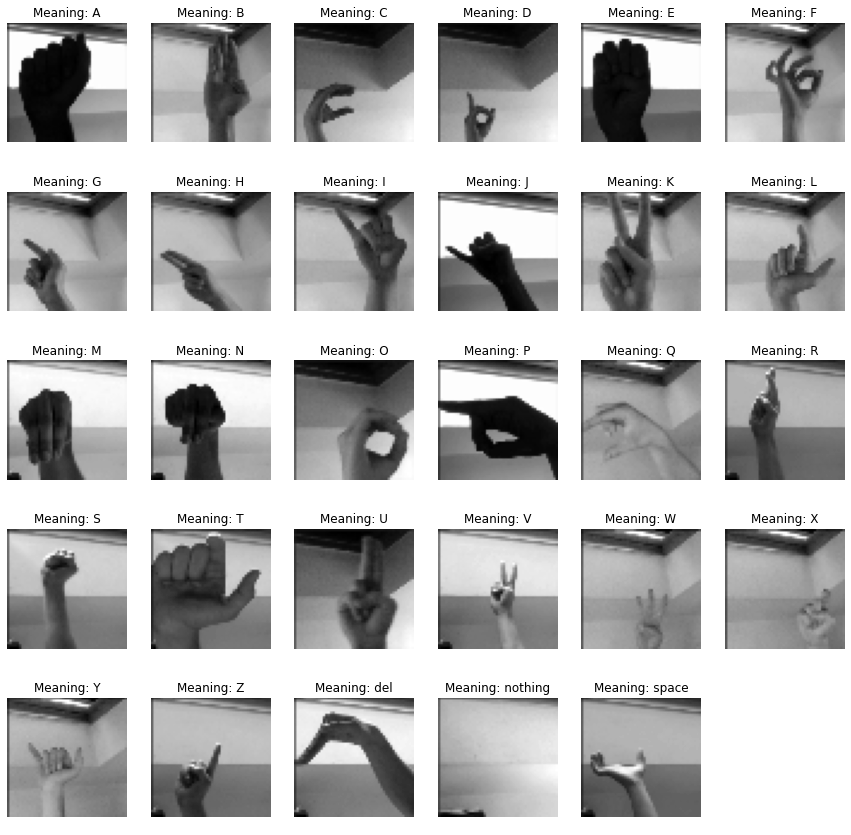

In [ ]:
fig, axs = plt.subplots(5,6, figsize=(15,15))
k = 0 
for i in range(5):
    for j in range(6):
      if k >= len(X): 
        axs[i, j].axis('off')
        break
      axs[i, j].imshow(X[k], cmap = 'gray') # per auto-canny
      axs[i, j].axis('off')
      axs[i, j].set_title('Meaning: ' + y[k])
      k = k + 1000

# Shallow learning: LOGIT

Creating train and test set

In [ ]:
X_res = X.reshape(len(X), X.shape[1]*X.shape[2])
xtrn, xtst, ytrn, ytst = train_test_split(X_res, y_num, test_size = 0.3, random_state = 1998)

I have made some tries but the algorithm don't converge: probably it is the case of a non-linear problem.

1st try: logistic regression with some regularization.

In [ ]:
model = LogisticRegression()
gs = GridSearchCV(estimator=model, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
gs.fit(xtrn, ytrn)

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

2nd try: logistic regression regularized on auto_canny images.

In [ ]:
X_canny = np.empty(X.shape)
for i in tqdm(range(len(X))):
  X_canny[i] = imutils.auto_canny(np.uint8(X[i]))

100%|██████████████████████████████████████████████████████████████| 29000/29000 [00:09<00:00, 2939.46it/s]


plotting the results

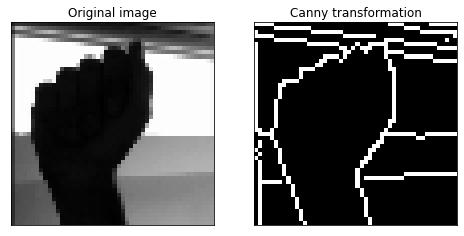

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(X[0], cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(X_canny[0], cmap='gray')
ax[1].set_title('Canny transformation');
plt.show()

In [ ]:
X_canny_res = X_canny.reshape(len(X_canny), X_canny.shape[1]*X_canny.shape[2])
xtrn_canny, xtst_canny, ytrn_canny, ytst_canny = train_test_split(X_canny_res, y_num, test_size = 0.3, random_state = 1998)

In [ ]:
model = LogisticRegression()
gs = GridSearchCV(estimator=model, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
gs.fit(xtrn_canny, ytrn_canny)

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

3rd try: logistic regression regularized on HOG images.

In [ ]:
X_hog = np.empty(X.shape)
for i in tqdm(range(len(X))):
  hog_vec, X_hog[i] = hog(X[i], visualize=True, block_norm='L1')

100%|███████████████████████████████████████████████████████████████| 29000/29000 [01:50<00:00, 262.51it/s]


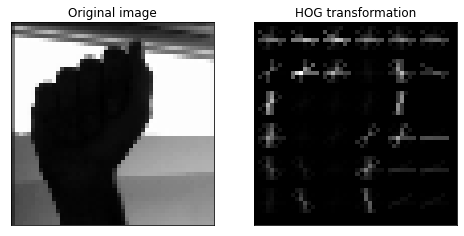

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(X[0], cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(X_hog[0], cmap='gray')
ax[1].set_title('HOG transformation');
plt.show()

In [ ]:
X_hog_res = X_canny.reshape(len(X_hog), X_hog.shape[1]*X_hog.shape[2])
xtrn_hog, xtst_hog, ytrn_hog, ytst_hog = train_test_split(X_hog_res, y_num, test_size = 0.3, random_state = 1998)

In [ ]:
model = LogisticRegression()
gs = GridSearchCV(estimator=model, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
gs.fit(xtrn_hog, ytrn_hog)

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Utente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})